In [25]:
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 5000)

In [27]:
br_ecomm_jan17_dec17 = pd.read_csv('../data/br_ecomm_jan17_dec17.csv')
print(list(br_ecomm_jan17_dec17))

['order_purchase_date', 'order_id', 'customer_id_for_order', 'order_status', 'order_delivered_carrier_date', 'customer_unique_id', 'customer_zip_code_prefix', 'order_item_id', 'product_id', 'seller_id', 'seller_zip_code_prefix', 'customer_lat', 'customer_long', 'seller_lat', 'seller_long', 'cust_lat_long', 'seller_lat_long', 'seller_cust_geo_dist', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_name', 'product_weight_kgs', 'product_volume_cubic_mts']


In [31]:
import os
# Had to set the path of PROJ_LIB otherwise it was throwing key error during import
os.environ["PROJ_LIB"] = os.path.join(os.environ["CONDA_PREFIX"], "share", "proj")
from mpl_toolkits.basemap import Basemap

### Geo mapping using Geo-Pandas

In [71]:
import descartes

# Was thowing AttributeError: partially initialized module 'fiona'
# has no attribute '_loading' (most likely due to a circular import)
# so did conda update fiona coz the circular import issue was resolved in 
# version 1.8.16 --> https://github.com/Toblerity/Fiona/issues/944
import geopandas as gpd

from shapely.geometry import Point, Polygon

<AxesSubplot:>

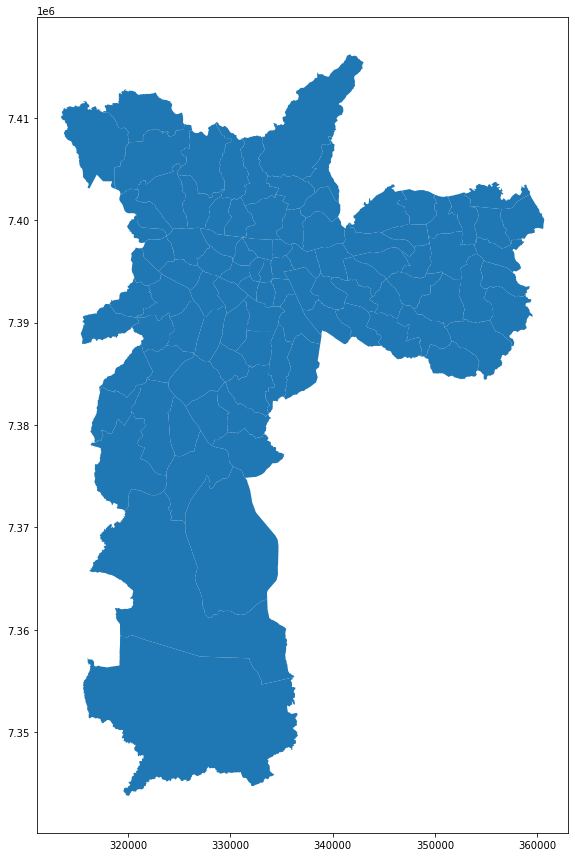

In [128]:
# import street map
# street_map = gpd.read_file('../data/sao_paulo_st_shp/sao_paulo.shp')

fig, ax = plt.subplots(figsize=(15, 15))

street_map = gpd.read_file('../data/sao_paulo_city_shp/SAD69-96_SHP_distrito_polygon.shp')
# was getting Set SHAPE_RESTORE_SHX config option to YES to restore or create it
# sol: all related files (.shx, .prj, .dbfx) should be in the same folder
# src: https://stackoverflow.com/questions/61436956/set-shape-restore-shx-config-option-to-yes-to-restore-or-create-it


"""
The above shp file and sp/sp_municipios/35MUE250GC_SIR.shp are for SP state.

To get city SHP file:
http://br-cities.survey.okfn.org/entry/sp/map
--> http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx#
--> download file --> chose administrative limits --> district 
{
coz as per free dict (https://www.thefreedictionary.com/city+limits)
--> city - an incorporated administrative district established by state charter; "the city raised the tax rate"
}

--> dxf, kmz, shapefile
"""

street_map.plot(ax=ax)

In [129]:
# A CRS tells Python how those coordinates relate to places on the Earth.
# --> https://geopandas.org/projections.html
# Designate coordinate system
 
"""
crs = {'init': 'espc:4326'}
The above crs throwing CRSError: Invalid projection: +init=espc:4326 +type=crs: (Internal Proj Error: proj_create: cannot expand +init=espc:4326 +type=crs)
"""

crs = {'init': 'epsg:4326'}

In [130]:
br_ecomm_jan17_dec17_lat_long_grp = br_ecomm_jan17_dec17.groupby(['customer_lat', 'customer_long'])['order_id'].count().reset_index()
print(br_ecomm_jan17_dec17_lat_long_grp)
print(type(br_ecomm_jan17_dec17_lat_long_grp))

      customer_lat  customer_long  order_id
0       -23.879082     -46.738881         1
1       -23.877859     -46.659051         1
2       -23.863590     -46.712031         2
3       -23.859200     -46.708474         1
4       -23.852049     -46.715440         1
...            ...            ...       ...
1103    -23.409922     -46.739024         1
1104    -23.406405     -46.742983         1
1105    -23.405642     -46.760371         3
1106    -23.402011     -46.749601         2
1107    -23.399076     -46.750619         4

[1108 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


In [131]:
geometry = [Point(xy) for xy in zip(br_ecomm_jan17_dec17_lat_long_grp['customer_lat'], br_ecomm_jan17_dec17_lat_long_grp['customer_long'])]
geometry[:3]

In [132]:
geo_df = gpd.GeoDataFrame(br_ecomm_jan17_dec17_lat_long_grp,
                         crs = crs,
                         geometry = geometry)

geo_df.head()

/Users/salma/anaconda3/envs/brazilian_e-commerce_data/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,customer_lat,customer_long,order_id,geometry
0,-23.879082,-46.738881,1,POINT (-23.87908 -46.73888)
1,-23.877859,-46.659051,1,POINT (-23.87786 -46.65905)
2,-23.863590,-46.712031,2,POINT (-23.86359 -46.71203)
3,-23.859200,-46.708474,1,POINT (-23.85920 -46.70847)
4,-23.852049,-46.715440,1,POINT (-23.85205 -46.71544)


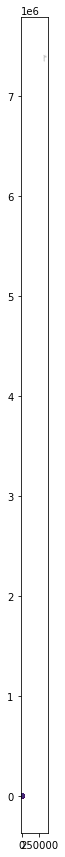

In [133]:
fig, ax = plt.subplots(figsize=(30,15))

# add .shp mapfile to axes
street_map.plot(ax = ax, alpha = 0.4, color='grey')

# add geodf to axes
# specify the variable to represent co-ods on graph
# assign size of points using marker size
geo_df.plot(column = 'order_id', ax = ax, markersize = 20)

# plt.xlim(-46.80689734, -46.37081356)
# plt.ylim(-23.8790822, -23.39907641)

plt.show()

### Geo-mapping using BaseMap

'\nShowing a very zoomed out view of SP city location.\nNot sure how to zoom in only to the SP city locations\n\nTried to give \nplt.xlim(-46.80689734, -46.37081356)\nplt.ylim(-23.8790822, -23.39907641) \nbut didnt work\n'

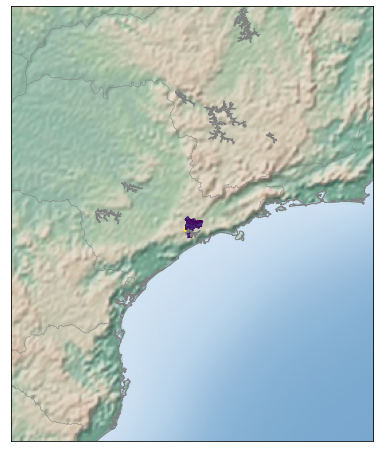

In [119]:
# Draw the map background
# -23.5475 -46.63611 - https://latitude.to/map/br/brazil/cities/sao-paulo
import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = (30,30)
# trying rc params above to zoom in on only sao paulo
fig = plt.figure(figsize=(8,8))

# had to conda install -c conda-forge basemap-data-hires otherwise was throwing issues with resolution 'h'

"""
lon_0	center of desired map domain (in degrees).
lat_0	center of desired map domain (in degrees).


lat_0	central latitude (y-axis origin) - used by all projections.
lon_0	central meridian (x-axis origin) - used by all projections.


Sao Paulo:
City Coordinates: 23°33′S 46°38′W --> https://www.nationsonline.org/oneworld/map/google_map_Sao_Paulo.htm

Based on above, 
Lat Long
(-23.548670, -46.638248) 
--> https://www.latlong.net/

Try different options using

"""
m = Basemap(projection='lcc', resolution='h',
            lat_0 = -23.55,
            lon_0 = -46.64,
            width=1E6, height=1.2E6)


m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# scatter customer lat, long with color reflecting orders and size reflecting area
m.scatter(br_ecomm_jan17_dec17_lat_long_grp['customer_long'].values, br_ecomm_jan17_dec17_lat_long_grp['customer_lat'].values,
         latlon=True, c=br_ecomm_jan17_dec17_lat_long_grp['order_id'].values,
         s = br_ecomm_jan17_dec17_lat_long_grp['order_id'].values)

"""
Showing a very zoomed out view of SP city location.
Not sure how to zoom in only to the SP city locations

Tried to give 
plt.xlim(-46.80689734, -46.37081356)
plt.ylim(-23.8790822, -23.39907641) 
but didnt work
"""